In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
df = pd.read_csv('bank.csv',sep=';')
df = df.drop(['day'],axis=1)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   month      4521 non-null   object
 10  duration   4521 non-null   int64 
 11  campaign   4521 non-null   int64 
 12  pdays      4521 non-null   int64 
 13  previous   4521 non-null   int64 
 14  poutcome   4521 non-null   object
 15  y          4521 non-null   object
dtypes: int64(6), object(10)
memory usage: 565.2+ KB


In [4]:
## checking null values
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

## 1. Data preprocessing

In [5]:
## job
df['job'].value_counts()

management       969
blue-collar      946
technician       768
admin.           478
services         417
retired          230
self-employed    183
entrepreneur     168
unemployed       128
housemaid        112
student           84
unknown           38
Name: job, dtype: int64

In [6]:
job_stats = df['job'].value_counts().sort_values(ascending=True)>200
job_count_greater_than_200 = job_stats[job_stats].index.to_list()


In [7]:
df['job'] = df['job'].apply(lambda x: x if x in job_count_greater_than_200 else 'other')

In [8]:
## month 

df['month'].value_counts()

may    1398
jul     706
aug     633
jun     531
nov     389
apr     293
feb     222
jan     148
oct      80
sep      52
mar      49
dec      20
Name: month, dtype: int64

In [9]:
month_stat= df['month'].value_counts()>250
month_df_greater_than_250= month_stat[month_stat].index.to_list()

In [10]:
df['month'] = df['month'].apply(lambda x: x if x in month_df_greater_than_250 else 'other_month')
df['month'].value_counts()

may            1398
jul             706
aug             633
other_month     571
jun             531
nov             389
apr             293
Name: month, dtype: int64

### 1.1 categorical and numerical features

In [11]:
## categorical_features
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'O']
cat_df = df[categorical_features]

## numerical_features
numerical_features = [feature for feature in df.columns if df[feature].dtype != 'O']
num_df = df[numerical_features]

In [12]:
## label encoding
def label_encoding(data, feature):
    ordinal_label = {k:i for i,k in enumerate(data[feature].unique())}
    encoded = data[feature].map(ordinal_label)
    return encoded

In [13]:
len(categorical_features)

10

In [14]:
## label encode before do chi square test
df1 = df.copy()
df1['job'] = label_encoding(df,'job' )
df1['marital'] = label_encoding(df,'marital' )
df1['education'] = label_encoding(df,'education' )
df1['default'] = label_encoding(df,'default' )
df1['housing'] = label_encoding(df,'housing' )
df1['loan'] = label_encoding(df,'loan' )
df1['poutcome'] = label_encoding(df,'poutcome' )
df1['month'] = label_encoding(df,'month' )
df1['y'] = label_encoding(df,'y' )

In [15]:
df1.head()

,age,job,marital,education,default,balance,housing,loan,contact,month,duration,campaign,pdays,previous,poutcome,y
0,30,0,0,0,0,1787,0,0,cellular,0,79,1,-1,0,0,0
1,33,1,0,1,0,4789,1,1,cellular,1,220,1,339,4,1,0
2,35,2,1,2,0,1350,1,0,cellular,2,185,1,330,1,1,0
3,30,2,0,2,0,1476,1,1,unknown,3,199,4,-1,0,0,0
4,59,3,0,1,0,0,1,0,unknown,1,226,1,-1,0,0,0


## 2. Outliers remove

### 2.1 Marital and Age relation

<AxesSubplot:title={'center':'age'}, xlabel='marital'>

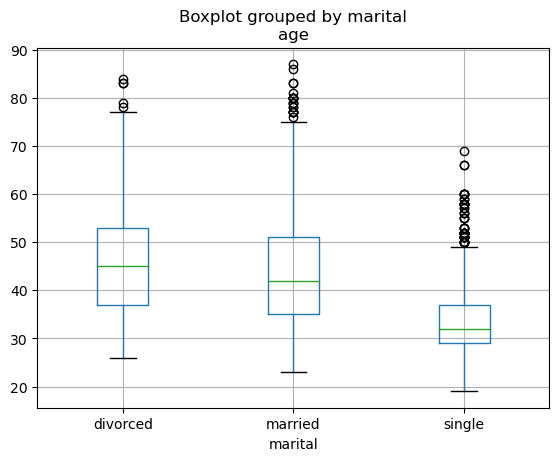

In [16]:
df.boxplot('age',by = 'marital')

In [17]:
## there is relation between age and martial status, so outliers should remove from this 

In [18]:
def remove_outliers_age_marital(data):
    df_out = pd.DataFrame()
    for key,subkey in data.groupby('marital'):
        m   = np.mean(subkey['age'])
        std = np.std (subkey['age'])
        
        removed_df = subkey[(subkey['age']>(m -2*std)) & (subkey['age']<(m + 2*std))]
        df_out = pd.concat([df_out,removed_df], ignore_index=True)
        
    return df_out

In [19]:
df2 = remove_outliers_age_marital(df)


<AxesSubplot:title={'center':'age'}, xlabel='marital'>

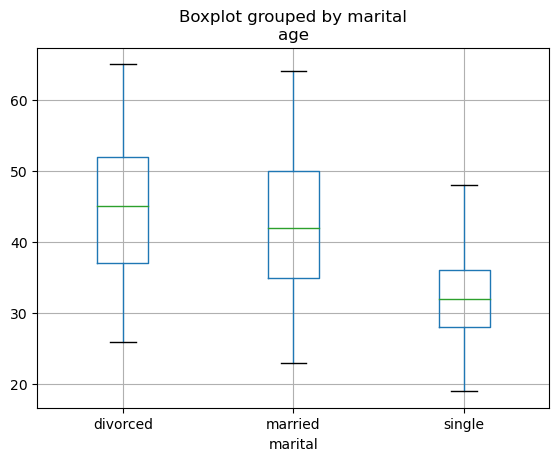

In [20]:
df2.boxplot('age',by = 'marital')

### 2.2 Balance, poutcome, campaign and y

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_theme(style="ticks", color_codes=True)

In [22]:
def plot_scatter_chart(df,poutcome):
    
    outcome_1 = df[(df.poutcome==poutcome) &(df2.campaign == 1)]
    outcome_2 = df[(df.poutcome==poutcome) &((df2['campaign']>=2) & (df2['campaign']<=4))]
    outcome_3 = df[(df.poutcome==poutcome) &(df2.campaign >= 5)]
    
    
    plt.rcParams['figure.figsize']=(8,6)
    plt.scatter( outcome_1.y, outcome_1.balance , color='blue', label='outcome_1',s=50)
    plt.scatter( outcome_2.y, outcome_2.balance , marker= '+' , color='green',label='outcome_2,3,4',s=60)
    plt.scatter( outcome_3.y, outcome_3.balance , marker= '*' , color='red',label='outcome_greater_5',s=40)
    
    plt.xlabel('campaign')
    plt.ylabel('balance')
    plt.title(poutcome)
    plt.legend()

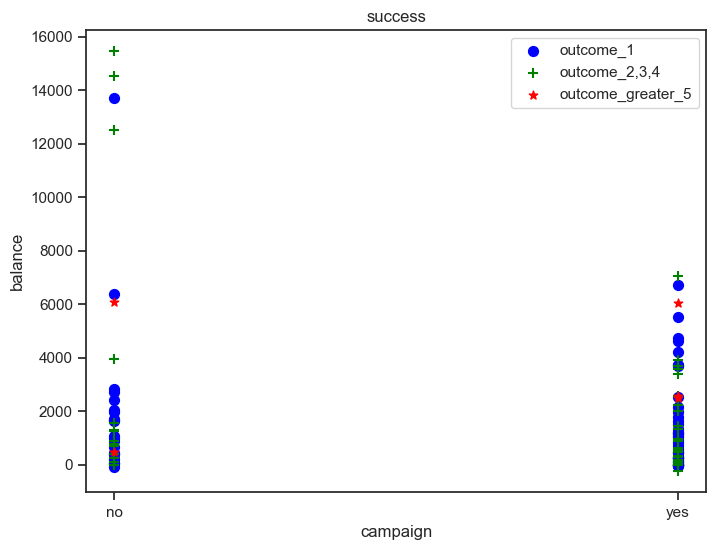

In [23]:
plot_scatter_chart(df2, 'success')

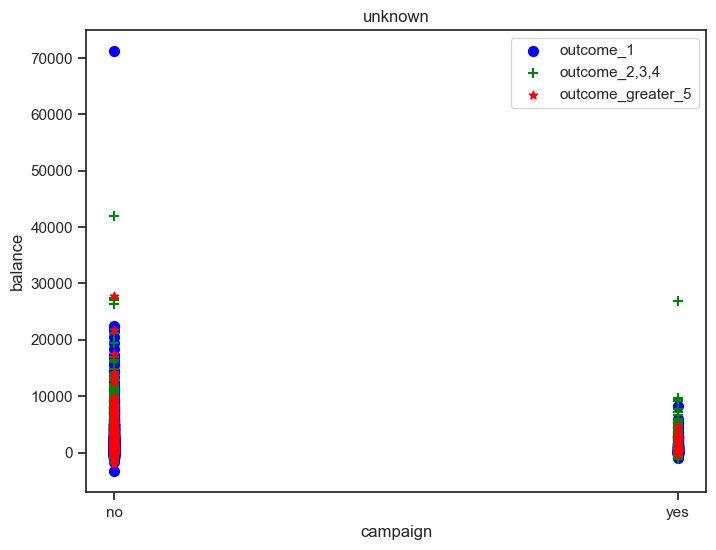

In [24]:
plot_scatter_chart(df2, 'unknown')

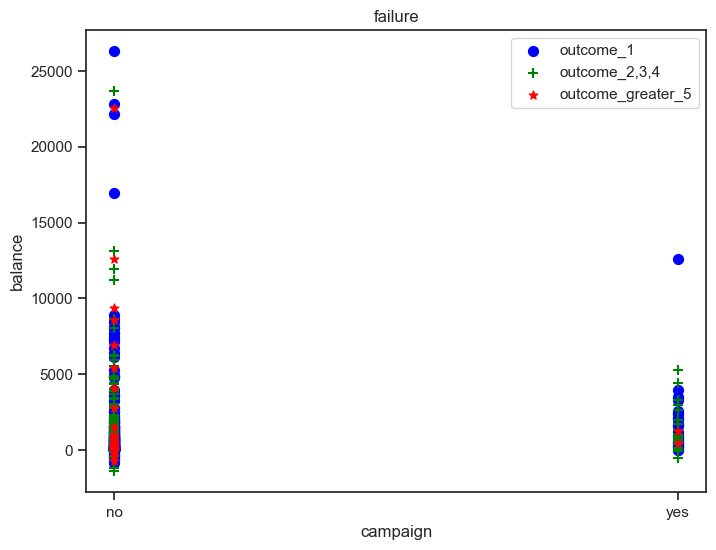

In [25]:
plot_scatter_chart(df2, 'failure')

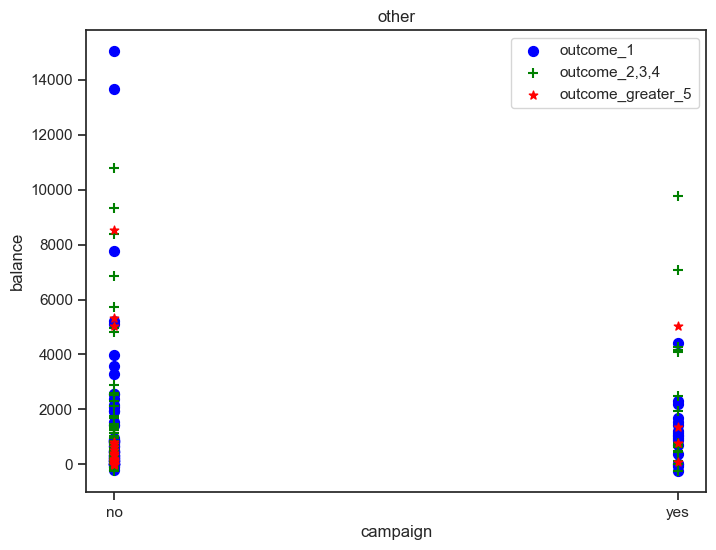

In [26]:
plot_scatter_chart(df2, 'other')

In [27]:
##  Outliers present in each category 

In [28]:
unkown_df = df2[df2['poutcome'] == 'unknown']
failure_df = df2[df2['poutcome'] == 'failure']
success_df = df2[df2['poutcome'] == 'success']
other_df = df2[df2['poutcome'] == 'other']

In [29]:
unkown_df_yes = unkown_df[unkown_df['y'] == 'yes']
unkown_df_no = unkown_df[unkown_df['y'] == 'no']

failure_df_yes = failure_df[failure_df['y'] == 'yes']
failure_df_no = failure_df[failure_df['y'] == 'no']

success_df_yes = success_df[success_df['y'] == 'yes']
success_df_no = success_df[success_df['y'] == 'no']

other_df_yes = other_df[other_df['y'] == 'yes']
other_df_no = other_df[other_df['y'] == 'no']

In [30]:
success_df = success_df[~((success_df['balance']>4000) & (success_df['campaign']>4))]

In [31]:
failure_df = failure_df[~((failure_df['balance']>10000) & (failure_df['campaign']>3))]

In [32]:
unkown_df = unkown_df[~((unkown_df['balance']>25000) & (unkown_df['campaign'] > 3)) ]

In [33]:
other_df_yes = other_df_yes[~((other_df_yes['balance']>4000) & (other_df_yes['campaign']>4))]

In [34]:
other_df_no = other_df_no[~((other_df_no['balance']>6000) & (other_df_no['campaign']>4))]

In [35]:
## Concat all data

In [36]:
df3 = df2.copy()

In [37]:
df3 = pd.concat([unkown_df,failure_df,other_df_no,other_df_yes,success_df])


### 2.3 Job and age relation

<AxesSubplot:title={'center':'age'}, xlabel='job'>

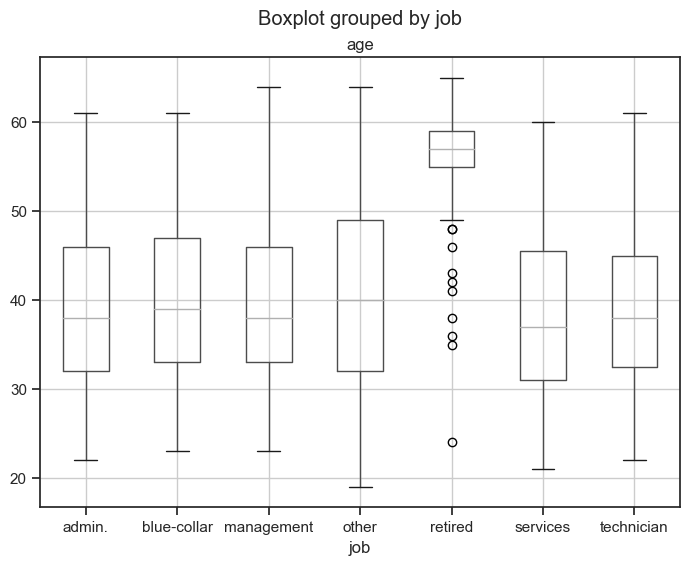

In [38]:
df3.boxplot('age',by = 'job')

#### Retired has some outliers, 

In [39]:
def remove_outliers_age_job(data):
    df_out = pd.DataFrame()
    for key,subkey in data.groupby('job'):
        m   = np.mean(subkey['age'])
        std = np.std (subkey['age'])
        
        removed_df = subkey[(subkey['age']>(m -2*std)) & (subkey['age']<(m + 2*std))]
        df_out = pd.concat([df_out,removed_df], ignore_index=True)
        
    return df_out

In [40]:
df3 = remove_outliers_age_job(df)

## 3. Statistical approch

In [41]:
## label encode before do chi square test
df4 = df3.copy()

df4['job'] = label_encoding(df3,'job' )
df4['marital'] = label_encoding(df3,'marital' )
df4['education'] = label_encoding(df3,'education' )
df4['default'] = label_encoding(df3,'default' )
df4['housing'] = label_encoding(df3,'housing' )
df4['loan'] = label_encoding(df3,'loan' )
df4['poutcome'] = label_encoding(df3,'poutcome' )
df4['month'] = label_encoding(df3,'month' )
df4['contact'] = label_encoding(df3,'contact' )
df4['y'] = label_encoding(df3,'y' )

### 3.1chi sqaured test

In [42]:
df4.head()

,age,job,marital,education,default,balance,housing,loan,contact,month,duration,campaign,pdays,previous,poutcome,y
0,43,0,0,0,0,264,0,0,0,0,113,2,-1,0,0,0
1,37,0,1,1,0,2317,0,0,0,0,114,1,152,2,1,0
2,53,0,0,0,0,105,1,1,0,1,74,2,-1,0,0,0
3,42,0,2,0,0,1811,0,0,1,2,150,1,-1,0,0,0
4,48,0,0,0,0,3064,0,0,2,3,159,2,-1,0,0,0


In [43]:
from sklearn.model_selection import train_test_split
x_train_chi, x_test_chi,  y_train_chi, y_test_chi  = train_test_split( df4[['job','marital','education','default','housing','loan','contact','month','poutcome']] ,
                                                      df4['y'],
                                                      test_size=0.3,
                                                      stratify=df4['y'],
                                                      random_state=42)

In [44]:
from sklearn.feature_selection import chi2
f_p_value = chi2(x_train_chi,y_train_chi)

In [45]:
## chi2 return 2 values
## f score, p_value
f_p_value

(array([2.84336415e+00, 1.04472899e+01, 9.27878428e-01, 2.06155344e-01,
        1.32471185e+01, 1.79148229e+01, 2.03079475e+01, 8.24131261e-01,
        2.62925017e+02]),
 array([9.17519338e-02, 1.22829540e-03, 3.35414822e-01, 6.49797642e-01,
        2.72999202e-04, 2.31014838e-05, 6.59261750e-06, 3.63975045e-01,
        3.95317233e-59]))

In [46]:
# high f value has more important feature
# lesser the p value more important feature 
f_value = pd.Series(f_p_value[0])
p_value = pd.Series(f_p_value[1])

In [47]:
p_value.index=x_train_chi.columns
p_value

job          9.175193e-02
marital      1.228295e-03
education    3.354148e-01
default      6.497976e-01
housing      2.729992e-04
loan         2.310148e-05
contact      6.592617e-06
month        3.639750e-01
poutcome     3.953172e-59
dtype: float64

In [48]:
f_value.index = x_train_chi.columns
f_value

job            2.843364
marital       10.447290
education      0.927878
default        0.206155
housing       13.247118
loan          17.914823
contact       20.307947
month          0.824131
poutcome     262.925017
dtype: float64

from the result of chi squared test, we got 2 values, p and f value. we select features by evaluate the p and f value. lesser the p value more important feature and  high f value has more important feature. Here Poutcome column has higher the f value and leser the p value. 

We selected Poutcome,housing,loan,marital,contact

In [49]:
## from this we can drop ['job','education','default','month']

### 3.2 Correlation

In [50]:
corr = df3.corr()
corr

,age,balance,duration,campaign,pdays,previous
age,1.000000,0.075073,-0.005867,0.005916,-0.016574,-0.007704
balance,0.075073,1.000000,-0.015900,-0.008728,0.012155,0.027817
duration,-0.005867,-0.015900,1.000000,-0.069838,0.007642,0.017358
campaign,0.005916,-0.008728,-0.069838,1.000000,-0.093081,-0.066227
pdays,-0.016574,0.012155,0.007642,-0.093081,1.000000,0.581832
previous,-0.007704,0.027817,0.017358,-0.066227,0.581832,1.000000


In [51]:
## No correlation between any numerical features

### 3.3 Droping unwanted columns

In [52]:
df5 =df3.copy()
df5 =df5.drop(['job','education','default','month'],axis=1)

## 4 .Preprocessing

In [54]:
df5['y'].value_counts()

no     3893
yes     493
Name: y, dtype: int64

### 4.1 balance the data

In [55]:
## its a imbalanced data
from imblearn.over_sampling import RandomOverSampler

In [56]:
os =  RandomOverSampler(random_state=42)

In [58]:
x_reshaped, y_reshaped = os.fit_resample((df5.drop(['y'],axis=1)), (df5['y']))

In [63]:
## concat the data
df6 = pd.concat([x_reshaped,y_reshaped],axis=1)
df6.shape

(7786, 12)

### 4.2 Train test data spli

In [69]:
df7 = pd.get_dummies(df6,drop_first=True)
df7.shape

(7786, 16)

In [71]:
# independent features 
x = df7.drop(['y_yes'],axis=1)

# dependent features 
y = df7['y_yes']

In [78]:
from sklearn.model_selection import train_test_split

In [75]:
x_train,x_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=42,
                                                  stratify=y,shuffle=True)

### 4.3 Transformations

In [79]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [80]:
scaler = StandardScaler(with_mean=False)

## 5. Modeling

In [81]:
from sklearn.model_selection import  GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score,classification_report,f1_score,confusion_matrix,precision_score,recall_score,f1_score,roc_auc_score

In [171]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_predict,cross_val_score

In [100]:
from sklearn.metrics import precision_score,recall_score,roc_curve,auc
from sklearn import metrics

In [84]:
models={'Logistic regression'     : LogisticRegression(),
        'Random forest classifier': RandomForestClassifier(),
        'Gradient boosting classifier': GradientBoostingClassifier()
       }

In [85]:
for name, model in models.items():
    ### construct a pipeline
    pipeline=Pipeline(steps=[
        ('scaling',scaler),
        ('Modeling',model)
    ])
    
    pipeline.fit(x_train,y_train)
    print(name+'___trained')

Logistic regression___trained
Random forest classifier___trained
Gradient boosting classifier___trained


In [86]:
for name, model in models.items():
    ### construct a pipeline
    pipeline=Pipeline(steps=[
        ('scaling',scaler),
        ('Modeling',model)
    ])
    

    y_predictions = pipeline.predict(x_test)
    print(name+'__accuracy score: {:.5f}'.format(accuracy_score(y_test,y_predictions)))  
    print(name+'__precision score: {:.5f}'.format(precision_score(y_test,y_predictions, average='weighted')))  
    print(name+'__recall_score:{:.5f}'.format(recall_score( y_test,y_predictions)))
    print(name+'__f1_score:{:.5f}'.format(f1_score(y_test,y_predictions)))
    print('-------------------------------------------------------------------')
    


Logistic regression__accuracy score: 0.79795
Logistic regression__precision score: 0.79981
Logistic regression__recall_score:0.75856
Logistic regression__f1_score:0.78966
-------------------------------------------------------------------
Random forest classifier__accuracy score: 0.96318
Random forest classifier__precision score: 0.96548
Random forest classifier__recall_score:0.99829
Random forest classifier__f1_score:0.96443
-------------------------------------------------------------------
Gradient boosting classifier__accuracy score: 0.85317
Gradient boosting classifier__precision score: 0.85487
Gradient boosting classifier__recall_score:0.88784
Gradient boosting classifier__f1_score:0.85809
-------------------------------------------------------------------


#### from these model Random forest classifier has good score than other classifer model, so we select Random forest classifer

### 5.1 Plot the confusin model

In [88]:
rand_clas = RandomForestClassifier()

In [89]:
rand_clas.fit(x_train,y_train)

RandomForestClassifier()

In [90]:
y_predictions = rand_clas.predict(x_test)

In [91]:
y_predictions = rand_clas.predict(x_test)

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


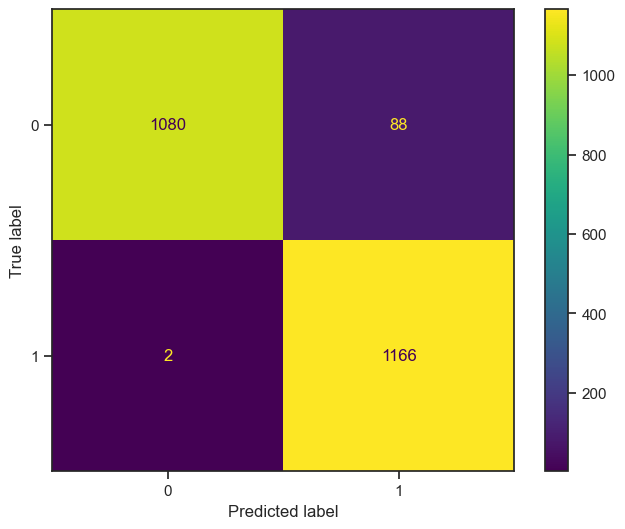

In [92]:
plot_confusion_matrix(rand_clas,x_test,y_test)

The accuracy score for the **random forest classifier** is **0.96318**, which means that the model correctly predicted **96.31%** of the samples in the test set. The **precision score** is also **0.96548**, which indicates that the model has a high precision, meaning that it has a low false positive rate. The **recall score** is **0.99829** indicating that the model has a high recall, meaning that it has a low false negative rate. The **F1 score** is **0.96443**, and it is a good measure of a model's balance between precision and recall. In general, these scores suggest that the random forest classifier is performing well on the dataset.

This model has given good result, So dont need to tune this model

## 6. Hyperparameter tuning

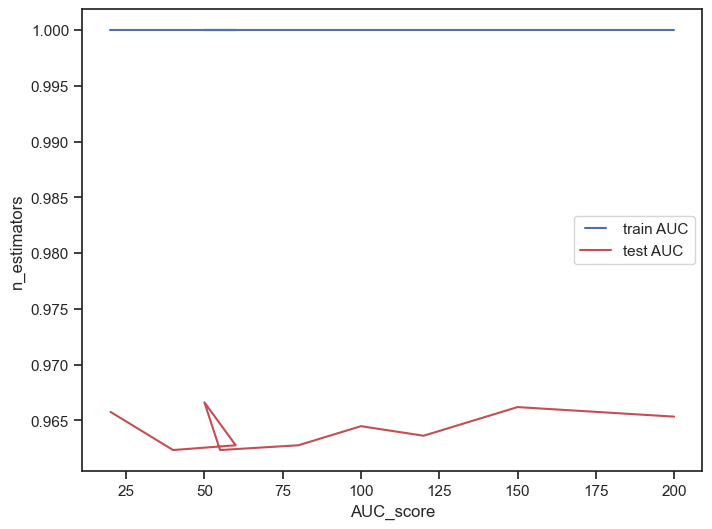

In [157]:
## curve for better optimizing

n_estimators = [20,40,60,50,55,80,100,120,150,200]
train_results = []
test_results = []

for estimators in n_estimators:
    
    rf = RandomForestClassifier(n_estimators=estimators, n_jobs=-1)
    rf.fit(x_train,y_train)
    train_pred1 = rf.predict(x_train)
    
    false_pos_rate, true_pos_rate, thresholds = roc_curve(y_train,train_pred1)
    roc_aus = auc(false_pos_rate,true_pos_rate)
    train_results.append(roc_aus)
    y_pred1 = rf.predict(x_test)
    false_pos_rate,true_pos_rate,thresholds = roc_curve(y_test,y_pred1)
    roc_aus = auc(false_pos_rate,true_pos_rate)
    test_results.append(roc_aus)
    
from matplotlib.legend_handler import HandlerLine2D

line_train, = plt.plot(n_estimators, train_results, 'b',label = 'train AUC')
line_test, = plt.plot(n_estimators, test_results, 'r',label = 'test AUC')

plt.legend(handler_map= {line_train: HandlerLine2D(numpoints=2)})
plt.xlabel('AUC_score')
plt.ylabel('n_estimators')
plt.show()

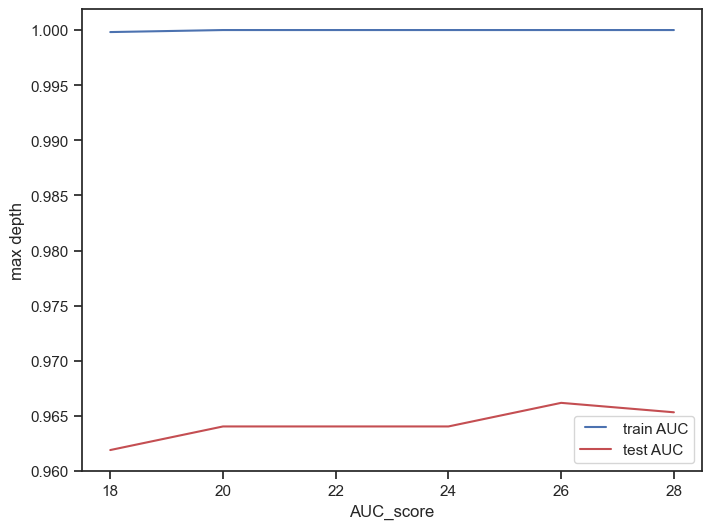

In [160]:
n_estimators =  [18,20,22,24,26,28]
train_results = []
test_results = []

for estimators in n_estimators:
    
    rf = RandomForestClassifier(max_depth=estimators, n_jobs=-1)
    rf.fit(x_train,y_train)
    train_pred1 = rf.predict(x_train)
    
    false_pos_rate, true_pos_rate, thresholds = roc_curve(y_train,train_pred1)
    roc_aus = auc(false_pos_rate,true_pos_rate)
    train_results.append(roc_aus)
    y_pred1 = rf.predict(x_test)
    false_pos_rate,true_pos_rate,thresholds = roc_curve(y_test,y_pred1)
    roc_aus = auc(false_pos_rate,true_pos_rate)
    test_results.append(roc_aus)
    
from matplotlib.legend_handler import HandlerLine2D

line_train, = plt.plot(n_estimators, train_results, 'b',label = 'train AUC')
line_test, = plt.plot(n_estimators, test_results, 'r',label = 'test AUC')

plt.legend(handler_map= {line_train: HandlerLine2D(numpoints=2)})
plt.xlabel('AUC_score')
plt.ylabel('max depth')
plt.show()

### Stratified K fold cross validation

In [172]:
from sklearn.model_selection import StratifiedKFold
skfold = StratifiedKFold(n_splits=5)
model1 = RandomForestClassifier()
scores = cross_val_score(model1,x,y,cv = skfold)

In [174]:
print(np.mean(scores))

0.965321134501275


## 7. About the model

### 7.1 Describing my model



The churn detection model that I am describing is a Random Forest Classifier, which is a type of ensemble learning method that combines multiple decision trees to create a more accurate and stable model.

The first step is to finding there is any missing value present in the data set. In this data there is no missing values are present. Then clean the data by perfoming outler calculation . in here there is high outlier on amount column. so clean outlier on amount colum. Then drop the unwanted column.

Once the data is prepared, the next step is to train the model. This involves using the prepared data to train various classifer algorithums. then calculate the accuracy score, recall score, precision score and F1 score. based on scores we select high perfoming algorithm. Here random forest classifier. The model is then fine-tuned using various techniques such as cross-validation and grid search to optimize the performance. But here we didnt required it. because it perfome very well even without tuning

Once the model is trained, it can be used to make predictions on new data(test data set). The model will take in the new data and use the trained mdoel to make a prediction about whether the churn or not. 

The Random Forest Classifier is a powerful and flexible model that can be used for churn detection. It is able to handle large amounts of data, handle non-linear relationships between features. Furthermore, it is less prone to overfitting than a single decision tree.

It's important to note that the performance of the model will depend on the quality and relevance of the data and features used to train it, so it's important to continuously monitor the model's performance and fine-tune it as necessary.


### 7.2 Selection of features

The **chi-squared test** is a statistical test that is used to determine the relationship between two categorical variables. It is often used in feature selection for categorical data to assess the independence of each feature with the target variable. The test calculates the chi-squared statistic, which measures the deviation of the observed values from the expected values under the assumption of independence. If the p-value of the test is less than a certain significance level (e.g. 0.05), it is concluded that there is a significant association between the two variables and the feature is considered for selection.


Here we preformed chi squared test and we got values, ie P value and f value. we select features by evaluate the p and f value. lesser the p value more important feature and high f value has more important feature. Here Poutcome column has higher the f value and leser the p value. We selected Poutcome,housing,loan,marital,contact. and drop  other features. 

**Correlation test** is a statistical measure that quantifies the strength and direction of the linear relationship between two numerical variables. It is often used in feature selection for numerical data to identify the features that have a strong relationship with the target variable. The correlation coefficient, commonly denoted by Pearson's r, ranges from -1 to 1, where -1 represents a perfect negative linear relationship, 1 represents a perfect positive linear relationship, and 0 represents no linear relationship. Features with high absolute correlation values (close to -1 or 1) are considered for selection because they have a strong relationship with the target variable. However, it's important to note that correlation only measures linear relationships and may not capture non-linear relationships between features and the target.


Here we don't get any correlation between any numerical features. we we select all numerical features.



 ### 7.3 Evaluation report

The accuracy score for the random forest classifier is 0.96318, which means that the model correctly predicted 96.31% of the samples in the test set. The precision score is also 0.96548, which indicates that the model has a high precision, meaning that it has a low false positive rate. The recall score is 0.99829 indicating that the model has a high recall, meaning that it has a low false negative rate. The F1 score is 0.96443, and it is a good measure of a model's balance between precision and recall. In general, these scores suggest that the random forest classifier is performing well on the dataset.


We only have 2 False negative prediction,  and 88 False positive. It means this model give good result And True positive is 1166, True negative is 1080 predictions. 
